In [113]:
# -----------------------------
# Data manipulation
# -----------------------------
import pandas as pd
import numpy as np
import json
import ast

# -----------------------------
# Plotting
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from io import StringIO

In [114]:
# URL for rank_by_year.csv
url_rank = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-09/rank_by_year.csv"

# Fetch CSV via requests (disable SSL verification temporarily)
response = requests.get(url_rank, verify=False)
csv_data = StringIO(response.text)

# Read into pandas DataFrame
rank_by_year = pd.read_csv(csv_data)

# Quick check
print("Rank by Year:")
print(rank_by_year)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



Rank by Year:
     code                country       region  rank  visa_free_count  year
0      AF            Afghanistan         ASIA   116               26  2021
1      AF            Afghanistan         ASIA   106               26  2020
2      AF            Afghanistan         ASIA   106               30  2018
3      AF            Afghanistan         ASIA   104               24  2017
4      AF            Afghanistan         ASIA   104               25  2016
...   ...                    ...          ...   ...              ...   ...
3945   PS  Palestinian Territory  MIDDLE EAST   102               37  2019
3946   PS  Palestinian Territory  MIDDLE EAST   105               37  2022
3947   PS  Palestinian Territory  MIDDLE EAST   103               38  2023
3948   PS  Palestinian Territory  MIDDLE EAST    98               40  2024
3949   PS  Palestinian Territory  MIDDLE EAST    93               39  2025

[3950 rows x 6 columns]


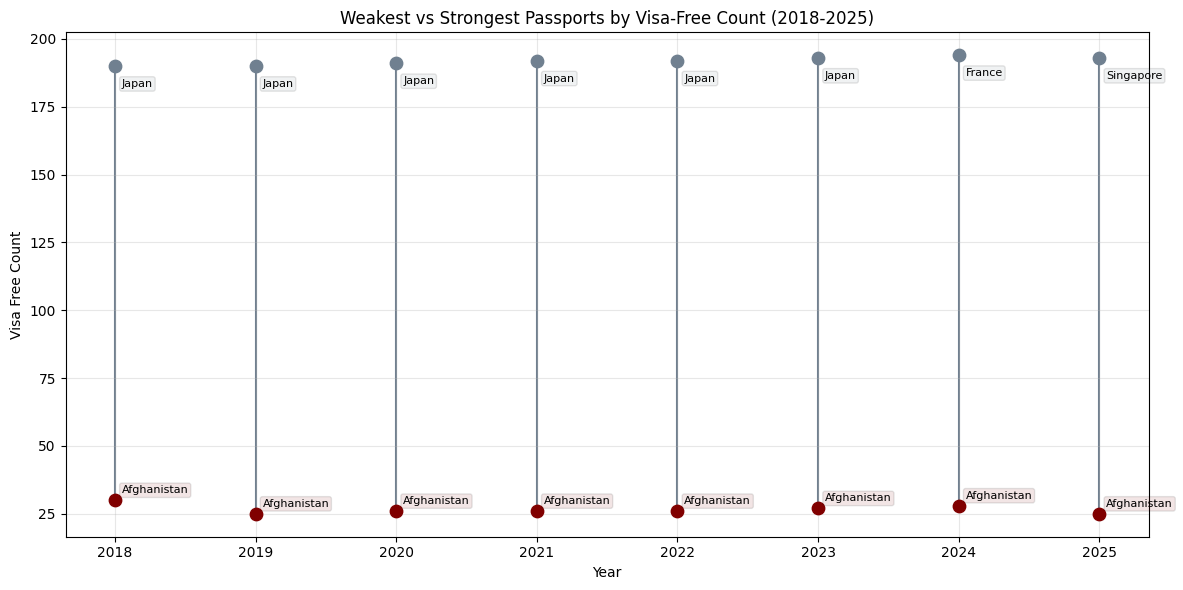

In [115]:
data = rank_by_year

data["year"] = pd.to_numeric(data["year"]).astype(int)
subset = data[(data['year'] >= 2018) & (data['year'] <= 2025)]


max_visa = subset.loc[subset.groupby('year')['visa_free_count'].idxmax()]
min_visa = subset.loc[subset.groupby('year')['visa_free_count'].idxmin()]

res = pd.concat([max_visa, min_visa]).sort_values('year')

res = res.pivot_table(index = "year", columns = "country", values = "visa_free_count", aggfunc = "first")
res_tidy = res.reset_index()
res_tidy.columns.name = None

fig, ax = plt.subplots(figsize=(12, 6))

min_countries = []
max_countries = []

for year in res_tidy['year']:
    year_data = res_tidy[res_tidy['year'] == year].drop('year', axis=1)
    
    # Find min (excluding NaNs)
    min_val = year_data.min().min()
    min_country = year_data.idxmin(axis=1).iloc[0]
    min_countries.append((year, min_country, min_val))
    
    # Find max (excluding NaNs)
    max_val = year_data.max().max()
    max_country = year_data.idxmax(axis=1).iloc[0]
    max_countries.append((year, max_country, max_val))

# Convert to DataFrames
min_df = pd.DataFrame(min_countries, columns=['year', 'country', 'value'])
max_df = pd.DataFrame(max_countries, columns=['year', 'country', 'value'])

# Plot minimum line
ax.scatter(min_df['year'], min_df['value'], 
          color='maroon', s=80, zorder=3)

# Plot maximum line  
ax.scatter(max_df['year'], max_df['value'], 
          color='slategray', s=80, zorder=3)

ax.vlines(max_df["year"], min_df["value"], max_df["value"], color = 'slategray', zorder = 1)

# Add country labels for each point
for idx, row in min_df.iterrows():
    ax.annotate(row['country'], (row['year'], row['value']),
                xytext=(5, 5), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='maroon', alpha=0.1))

for idx, row in max_df.iterrows():
    ax.annotate(row['country'], (row['year'], row['value']),
                xytext=(5, -15), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='slategray', alpha=0.1))

ax.set(xlabel='Year', ylabel='Visa Free Count',
       title='Weakest vs Strongest Passports by Visa-Free Count (2018-2025)')
ax.set_xticks(res_tidy['year'].astype(int))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [116]:
data.sort_values(by = ["country", "year"], ascending = True, inplace = True)

import plotly.express as px
import pandas as pd


# Create an animated choropleth map
fig = px.choropleth(
    data,
    locations = "country",
    locationmode = "country names",
    color = "visa_free_count",
    animation_frame = "year",   # 👈 this adds the time slider
    color_continuous_scale = "blues",
    projection = "natural earth",
    title = "Global Map with Time Slider"
)

fig.update_layout(
    geo = dict(showframe = False, showcoastlines = True),
    margin = dict(l = 0, r = 0, t = 30, b = 0)
)

fig.show()

/var/folders/zg/35mth8yj79ld1790wbwk9xr80000gn/T/ipykernel_4905/2191990181.py:8: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



In [117]:
max_year = rank_by_year['year'].max()
print(f"Max year in rank_by_year: {max_year}")

# Filter for the latest year
latest_rankings = rank_by_year[rank_by_year['year'] == max_year]
latest_rankings = latest_rankings.sort_values(by='rank')
print(latest_rankings)


Max year in rank_by_year: 2025
     code      country       region  rank  visa_free_count  year
2977   SG    Singapore         ASIA     1              193  2025
1669   JP        Japan         ASIA     2              190  2025
3097   KR  South Korea         ASIA     2              190  2025
1169   FR       France       EUROPE     3              189  2025
1629   IT        Italy       EUROPE     3              189  2025
...   ...          ...          ...   ...              ...   ...
3793   YE        Yemen  MIDDLE EAST    95               32  2025
2579   PK     Pakistan         ASIA    95               32  2025
1569   IQ         Iraq  MIDDLE EAST    96               30  2025
3335   SY        Syria  MIDDLE EAST    97               27  2025
19     AF  Afghanistan         ASIA    98               25  2025

[199 rows x 6 columns]


In [118]:
# URL for country_lists.csv
url_country = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-09-09/country_lists.csv"

# Fetch CSV via requests (disable SSL verification temporarily)
response = requests.get(url_country, verify=False)
csv_data = StringIO(response.text)

# Read into pandas DataFrame
country_lists = pd.read_csv(csv_data)

# Quick check
print("Country Lists:")
country_lists.head()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



Country Lists:


,code,country,visa_required,visa_online,visa_on_arrival,visa_free_access,electronic_travel_authorisation
0,PS,Palestinian Territory,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AG"",""name"":""Antigua and Barbuda""},{...","[[{""code"":""BD"",""name"":""Bangladesh""},{""code"":""B...","[[{""code"":""BO"",""name"":""Bolivia""},{""code"":""CK"",...","[[{""code"":""LK"",""name"":""Sri Lanka""},{""code"":""KE..."
1,AD,Andorra,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AO"",""name"":""Angola""},{""code"":""AZ"",""...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""JP"",""name"":""Japan""},{""code"":""AL"",""n...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."
2,VA,Vatican City,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AZ"",""name"":""Azerbaijan""},{""code"":""B...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""AL"",""name"":""Albania""},{""code"":""AD"",...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."
3,SM,San Marino,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AZ"",""name"":""Azerbaijan""},{""code"":""B...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""JP"",""name"":""Japan""},{""code"":""AL"",""n...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."
4,MC,Monaco,"[[{""code"":""AF"",""name"":""Afghanistan""},{""code"":""...","[[{""code"":""AZ"",""name"":""Azerbaijan""},{""code"":""B...","[[{""code"":""BH"",""name"":""Bahrain""},{""code"":""BD"",...","[[{""code"":""JP"",""name"":""Japan""},{""code"":""AL"",""n...","[[{""code"":""AU"",""name"":""Australia""},{""code"":""CA..."


In [119]:
json_cols = [
    'visa_required',
    'visa_online',
    'visa_on_arrival',
    'visa_free_access',
    'electronic_travel_authorisation'
]

import json

def clean_json_field(text):
    """Convert the messy stringified JSON fields into clean Python lists of dicts."""
    if pd.isna(text):
        return []
    try:
        data = json.loads(text)
        # Many fields are [[{...}]] — unwrap the extra list
        if isinstance(data, list) and len(data) == 1 and isinstance(data[0], list):
            data = data[0]
        return data
    except Exception as e:
        # Optional: print which rows failed to parse
        # print("Error parsing:", text[:80], e)
        return []
    
for col in json_cols:
    country_lists[col] = country_lists[col].apply(clean_json_field)

# Quick check
print("Cleaned Country Lists:")
country_lists.head()


Cleaned Country Lists:


,code,country,visa_required,visa_online,visa_on_arrival,visa_free_access,electronic_travel_authorisation
0,PS,Palestinian Territory,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AG', 'name': 'Antigua and Barbuda'}...","[{'code': 'BD', 'name': 'Bangladesh'}, {'code'...","[{'code': 'BO', 'name': 'Bolivia'}, {'code': '...","[{'code': 'LK', 'name': 'Sri Lanka'}, {'code':..."
1,AD,Andorra,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AO', 'name': 'Angola'}, {'code': 'A...","[{'code': 'BH', 'name': 'Bahrain'}, {'code': '...","[{'code': 'JP', 'name': 'Japan'}, {'code': 'AL...","[{'code': 'AU', 'name': 'Australia'}, {'code':..."
2,VA,Vatican City,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AZ', 'name': 'Azerbaijan'}, {'code'...","[{'code': 'BH', 'name': 'Bahrain'}, {'code': '...","[{'code': 'AL', 'name': 'Albania'}, {'code': '...","[{'code': 'AU', 'name': 'Australia'}, {'code':..."
3,SM,San Marino,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AZ', 'name': 'Azerbaijan'}, {'code'...","[{'code': 'BH', 'name': 'Bahrain'}, {'code': '...","[{'code': 'JP', 'name': 'Japan'}, {'code': 'AL...","[{'code': 'AU', 'name': 'Australia'}, {'code':..."
4,MC,Monaco,"[{'code': 'AF', 'name': 'Afghanistan'}, {'code...","[{'code': 'AZ', 'name': 'Azerbaijan'}, {'code'...","[{'code': 'BH', 'name': 'Bahrain'}, {'code': '...","[{'code': 'JP', 'name': 'Japan'}, {'code': 'AL...","[{'code': 'AU', 'name': 'Australia'}, {'code':..."


In [120]:
visa_cols = [
    'visa_required',
    'visa_online',
    'visa_on_arrival',
    'visa_free_access',
    'electronic_travel_authorisation'
]

from pandas import json_normalize

flat_frames = []

for col in visa_cols:
    temp = country_lists[['code', 'country', col]].explode(col)
    temp = temp.dropna(subset=[col])
    temp['visa_type'] = col
    temp['to_code'] = temp[col].apply(lambda x: x.get('code') if isinstance(x, dict) else None)
    temp['to_name'] = temp[col].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
    temp = temp.drop(columns=[col])
    flat_frames.append(temp)

# Combine all into one DataFrame
flat_df = pd.concat(flat_frames, ignore_index=True)

# Remove rows missing target country codes
flat_df = flat_df.dropna(subset=['to_code'])

# Drop duplicates if any
flat_df = flat_df.drop_duplicates(subset=['code', 'to_code', 'visa_type']).reset_index(drop=True)

# Optional: rename columns for clarity
flat_df.rename(columns={
    'code': 'from_code',
    'country': 'from_country'
}, inplace=True)


# Quick check
print("Flattened Visa Data:")
flat_df.head()

Flattened Visa Data:


,from_code,from_country,visa_type,to_code,to_name
0,PS,Palestinian Territory,visa_required,AF,Afghanistan
1,PS,Palestinian Territory,visa_required,DZ,Algeria
2,PS,Palestinian Territory,visa_required,AD,Andorra
3,PS,Palestinian Territory,visa_required,AO,Angola
4,PS,Palestinian Territory,visa_required,AI,Anguilla


In [121]:
visa_summary = flat_df.groupby('visa_type').size().reset_index(name='count')
print(visa_summary)


                         visa_type  count
0  electronic_travel_authorisation   1382
1                 visa_free_access  15066
2                  visa_on_arrival   5316
3                      visa_online   5817
4                    visa_required  17392


In [122]:
visa_by_country = (
    flat_df.groupby(['from_country', 'visa_type'])
    .size()
    .reset_index(name='destination_count')
    .sort_values(['from_country', 'visa_type'])
)

visa_pivot = visa_by_country.pivot(
    index='from_country',
    columns='visa_type',
    values='destination_count'
).fillna(0).astype(int)
visa_pivot = visa_pivot.reset_index()
print("Visa Counts by Country:")
visa_pivot.head()

Visa Counts by Country:


visa_type,from_country,electronic_travel_authorisation,visa_free_access,visa_on_arrival,visa_online,visa_required
0,Afghanistan,3,6,16,43,158
1,Albania,6,88,29,29,74
2,Algeria,2,26,27,39,132
3,Andorra,16,120,35,23,32
4,Angola,2,26,20,37,141


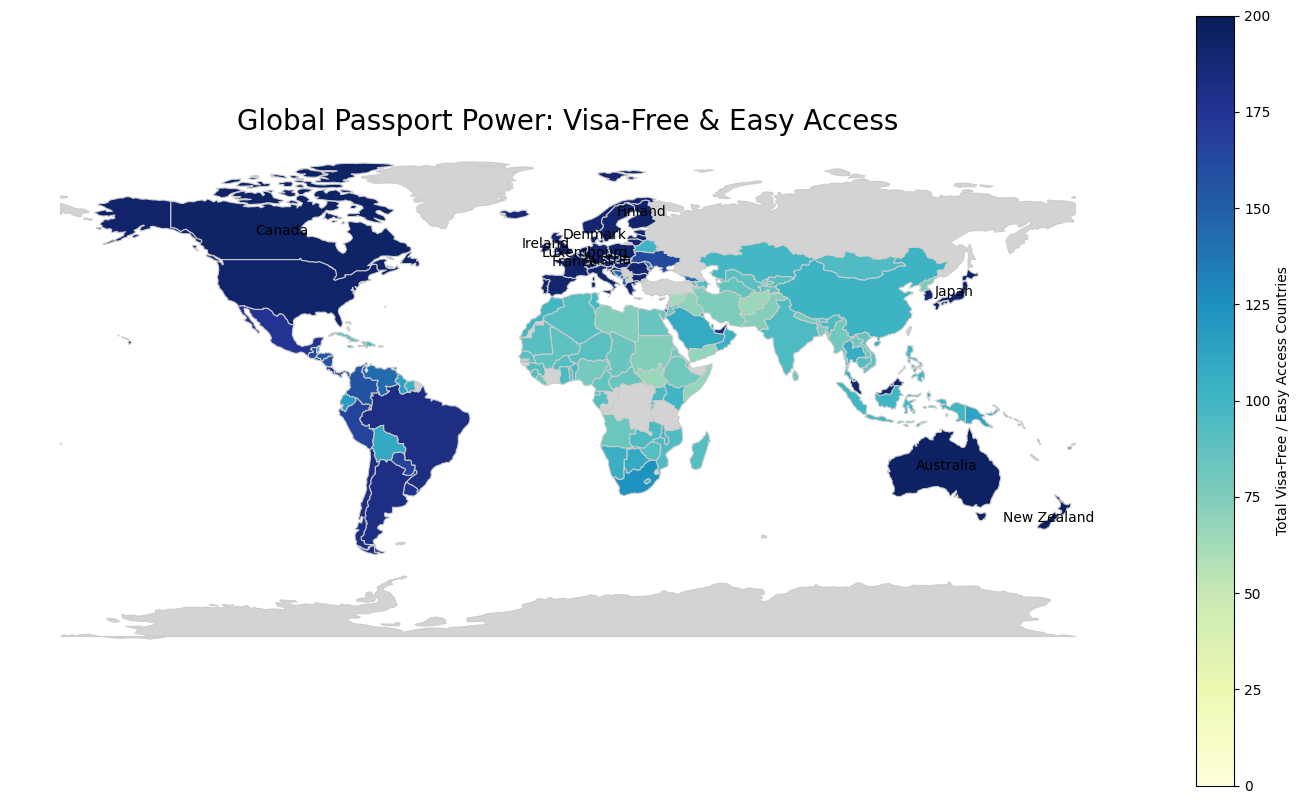

In [123]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Load the Natural Earth low-resolution world map
world = gpd.read_file("https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json")

# Example: total visa-free access
visa_pivot['total_visa_free'] = visa_pivot['visa_free_access'] + visa_pivot['visa_on_arrival'] + visa_pivot['visa_online']

# Fix country name mismatches
name_corrections = {
    "United States": "United States of America",
    "Russia": "Russian Federation",
    "Vatican City": "Vatican",
    "Palestinian Territory": "Palestine",
    "Czechia": "Czech Republic",
    # add more if needed
}
visa_pivot['from_country'] = visa_pivot['from_country'].replace(name_corrections)

# Merge world map with visa data
world_visa = world.merge(visa_pivot, how='left', left_on='name', right_on='from_country')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

world_visa.plot(
    column='total_visa_free',            # metric to color
    cmap='YlGnBu',                        # color palette
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Total Visa-Free / Easy Access Countries"},
    missing_kwds={"color": "lightgrey"},  # grey for missing countries
    vmin=0,
    vmax=200
)

# Annotate top 10 countries
for idx, row in world_visa.nlargest(10, 'total_visa_free').iterrows():
    geom = row['geometry']
    # Get centroid of the largest polygon if MultiPolygon
    if geom.geom_type == 'MultiPolygon':
        largest_poly = max(geom.geoms, key=lambda a: a.area)
        centroid = largest_poly.centroid
    else:  # Polygon
        centroid = geom.centroid
    ax.text(centroid.x, centroid.y, row['from_country'], fontsize=10, ha='center')

# Title and remove axis
ax.set_title("Global Passport Power: Visa-Free & Easy Access", fontsize=20)
ax.set_axis_off()

plt.show()





In [124]:
world_visa.head()

,id,name,geometry,from_country,electronic_travel_authorisation,visa_free_access,visa_on_arrival,visa_online,visa_required,total_visa_free
0,AFG,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066...",Afghanistan,3.0,6.0,16.0,43.0,158.0,65.0
1,AGO,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...",Angola,2.0,26.0,20.0,37.0,141.0,83.0
2,ALB,Albania,"POLYGON ((20.59025 41.8554, 20.46318 41.51509,...",Albania,6.0,88.0,29.0,29.0,74.0,146.0
3,ARE,United Arab Emirates,"POLYGON ((51.57952 24.2455, 51.75744 24.29407,...",United Arab Emirates,10.0,143.0,31.0,11.0,31.0,185.0
4,ARG,Argentina,"MULTIPOLYGON (((-65.5 -55.2, -66.45 -55.25, -6...",Argentina,9.0,127.0,34.0,20.0,36.0,181.0


In [125]:
# Group by region
region_stats = latest_rankings.groupby('region').agg(
    avg_visa_free=('visa_free_count', 'mean'),   # average visa-free count
    max_visa_free=('visa_free_count', 'max'),    # strongest passport in the region
    top_country=('country', lambda x: latest_rankings.loc[x.index, 'visa_free_count'].idxmax())
).reset_index()

# Sort by strongest passport
region_stats = region_stats.sort_values(by='max_visa_free', ascending=False)

print(region_stats)


        region  avg_visa_free  max_visa_free  top_country
2         ASIA      86.000000            193         2977
4       EUROPE     165.265306            189         1169
6      OCEANIA     124.357143            187         2439
1     AMERICAS     136.545455            184          599
5  MIDDLE EAST      77.733333            184         3633
3    CARIBBEAN     126.230769            163          279
0       AFRICA      62.259259            156         2937


In [126]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

# latest_rankings: ['country', 'region', 'visa_free_count']
regions = latest_rankings['region'].unique()
colors = px.colors.qualitative.Plotly[:len(regions)]
region_colors = dict(zip(regions, colors))

# --- Box traces per region ---
box_traces = []
for region in regions:
    df = latest_rankings[latest_rankings['region']==region]
    box = go.Box(
        y=df['visa_free_count'],
        name=region,
        boxpoints='outliers',
        marker=dict(size=8, line=dict(width=1.5), color=region_colors[region]),
        line=dict(color=region_colors[region], width=2),
        boxmean='sd',
        hovertemplate="Region: "+region+"<br>Country: %{customdata}<br>Visa-Free: %{y}",
        customdata=df['country']
    )
    box_traces.append(box)

# --- Regional Average Bar ---
region_stats = latest_rankings.groupby('region', as_index=False).agg(avg_visa_free=('visa_free_count','mean'))
bar_trace = go.Bar(
    x=region_stats['region'],
    y=region_stats['avg_visa_free'],
    name='Regional Average',
    marker_color=[region_colors[r] for r in region_stats['region']],
    text=region_stats['avg_visa_free'].round(1),
    textposition='outside'
)

# --- Country-level Bars ---
region_bar_traces = []
for region in regions:
    df = latest_rankings[latest_rankings['region']==region].sort_values('visa_free_count', ascending=False)
    trace = go.Bar(
        x=df['country'],
        y=df['visa_free_count'],
        name=f'{region} Countries',
        marker_color=region_colors[region],
        text=df['visa_free_count'],
        textposition='outside',
        hovertemplate="Country: %{x}<br>Visa-Free: %{y}"
    )
    region_bar_traces.append(trace)

# --- Combine Traces ---
fig = go.Figure(data=box_traces + [bar_trace] + region_bar_traces)

# Make only the box plot visible initially
for i in range(len(box_traces), len(fig.data)):
    fig.data[i].visible = False

# --- Buttons ---
buttons = []

# Box plot
buttons.append(dict(
    label='📊 Box Plot',
    method='update',
    args=[{'visible':[True]*len(box_traces)+[False]*(1+len(region_bar_traces))},
          {'title':'Visa-Free Distribution by Region',
           'yaxis':{'type':'log','title':'Visa-Free Destinations'}}]
))

# Regional average
visibility = [False]*len(box_traces) + [True] + [False]*len(region_bar_traces)
buttons.append(dict(
    label='🌍 Regional Average',
    method='update',
    args=[{'visible':visibility},
          {'title':'Average Visa-Free by Region',
           'yaxis':{'type':'log','title':'Visa-Free Destinations'}}]
))

# Country-level per region
for i, region in enumerate(regions):
    visibility = [False]* (len(box_traces)+1) + [False]*len(region_bar_traces)
    visibility[len(box_traces)+1+i] = True
    buttons.append(dict(
        label=f'🏳️ {region}',
        method='update',
        args=[{'visible':visibility},
              {'title':f'Visa-Free Access by Country in {region}',
               'yaxis':{'type':'log','title':'Visa-Free Destinations'}}]
    ))

# --- Layout ---
fig.update_layout(
    width=1600,
    height=900,
    updatemenus=[dict(
        type='dropdown',
        buttons=buttons,
        x=0.5,
        xanchor='center',
        y=1.25,
        yanchor='top'
    )],
    template='plotly_white',
    margin=dict(t=150,l=100,r=100,b=120),
    font=dict(size=16),
    plot_bgcolor='rgba(240,240,240,0.95)',
    paper_bgcolor='white'
)

fig.show()





In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by max_visa_free
region_stats_sorted = region_stats.sort_values('max_visa_free', ascending=True)

plt.figure(figsize=(12,8))

# Use a modern, vibrant palette
colors = sns.color_palette("rocket", len(region_stats_sorted))

# Horizontal bars for max visa-free
bar = plt.barh(
    region_stats_sorted['region'],
    region_stats_sorted['max_visa_free'],
    color=colors
)

# Overlay average visa-free as gold dots
plt.scatter(
    region_stats_sorted['avg_visa_free'],
    region_stats_sorted['region'],
    color='gold',
    s=120,
    label='Average Visa-Free Count',
    zorder=5
)

# Add value labels for max visa-free
for i, value in enumerate(region_stats_sorted['max_visa_free']):
    plt.text(value + 1, i, str(value), va='center', fontsize=10)

# Set x-axis limits
plt.xlim(50, 200)

plt.title("Strongest Passports by Region (2025)", fontsize=18, weight='bold')
plt.xlabel("Visa-Free / Easy Access Destinations", fontsize=12)
plt.ylabel("Region", fontsize=12)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




KeyError: 'max_visa_free'

In [38]:
import plotly.express as px
import pandas as pd

# Example data
df = pd.DataFrame({
    'country': ['United States', 'United States', 'China', 'China', 'India', 'India'],
    'year': [2000, 2020, 2000, 2020, 2000, 2020],
    'value': [100, 150, 80, 200, 50, 130]
})

# Create an animated choropleth map
fig = px.choropleth(
    df,
    locations="country",
    locationmode="country names",
    color="value",
    animation_frame="year",   # 👈 this adds the time slider
    color_continuous_scale="Viridis",
    projection="natural earth",
    title="Global Map with Time Slider"
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    margin=dict(l=0, r=0, t=30, b=0)
)

fig.show()
df.head()

/var/folders/zg/35mth8yj79ld1790wbwk9xr80000gn/T/ipykernel_4905/1132229147.py:12: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



,country,year,value
0,United States,2000,100
1,United States,2020,150
2,China,2000,80
3,China,2020,200
4,India,2000,50
